In [1]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 29.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 37.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139097 sha256=ba41dfb014f0701abcf1cb78d82ca926616b3018b752fe31d02eafe2f5a41b3a
  Stored in directory: c:\users\atul1\appdata\local\pip\cache\wheels\1a\57\6a\bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Successfully built peewee



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip install prophet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 4.2 MB/s eta 0:00:04
   --- ------------------------------------ 1.3/13.3 MB 3.9 MB/s eta 0:00:04
   ------ --------------------------------- 2.1/13.3 MB 3.8 MB/s eta 0:00:03
   -------- ------------------------------- 2.9/13.3 MB 3.8 MB/s eta 0:00:03
   ----------- ---------------------------- 3.7/13.3 MB 3.8 MB/s eta 0:00:03
   ------------- -------------------------- 4.5/13.3 MB 3.8 MB/s eta 0:00:03
   --------------- ------------------------ 5.2/13.3 MB 3.8 MB/s eta 0:00:03
   ----------------- ---------------------- 5.8/13.3 MB 3.7 MB/s eta 0:00:03
   ------------------- -------------------- 6.6/13.3 MB 3.7 MB/s eta 0:00:02
   ---------------------- ----------------- 7.6/13.3 MB 3.7 MB/s eta 0:00:02
   ------------------------- -------------- 8.4/13.3 MB 3.8 MB/s eta 0:00:02
   ---------------------------- ----------- 9.4/13.3 MB 3.8 MB/s eta 0:00:02
   --

In [43]:
import pandas as pd
import yfinance as yf
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from xgboost import XGBClassifier, plot_importance


In [40]:
DATA_DIR = os.path.join('.', 'data')
SNP500_COMPANIES_FILE_PATH = os.path.join(DATA_DIR, 'sp500_companies.csv')
SNP500_INDEX_FILE_PATH     = os.path.join(DATA_DIR, 'sp500_index.csv')
SNP500_STOCKS_FILE_PATH    = os.path.join(DATA_DIR, 'sp500_stocks.csv')

In [41]:

def load_sp500_data(sp500_companies, sp500_index, sp500_stocks):
    # Check file existence
    for file_path in [sp500_companies, sp500_index, sp500_stocks]:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

    # Load files
    df_companies = pd.read_csv(sp500_companies)
    df_index     = pd.read_csv(sp500_index, parse_dates=["Date"])
    df_stocks    = pd.read_csv(sp500_stocks, parse_dates=["Date"])

    # Log stock record count
    print(f"df_stocks Row count (before dropna): {df_stocks.shape[0]}")
    df_stocks = df_stocks.dropna()
    print(f"df_stocks Row count (after dropna): {df_stocks.shape[0]}")

    return df_companies, df_index, df_stocks

df_sp500_companies, df_sp500_index, df_sp500_stocks = load_sp500_data(SNP500_COMPANIES_FILE_PATH, SNP500_INDEX_FILE_PATH, SNP500_STOCKS_FILE_PATH)


df_stocks Row count (before dropna): 1891536
df_stocks Row count (after dropna): 617831


In [42]:
df_companies_and_stock = pd.merge(
    df_sp500_stocks,
    df_sp500_companies,
    on="Symbol",
    how="inner"
)
row_count = df_companies_and_stock.shape[0]
print("df_companies_and_stock Row count:", row_count)




df_companies_and_stock Row count: 617831


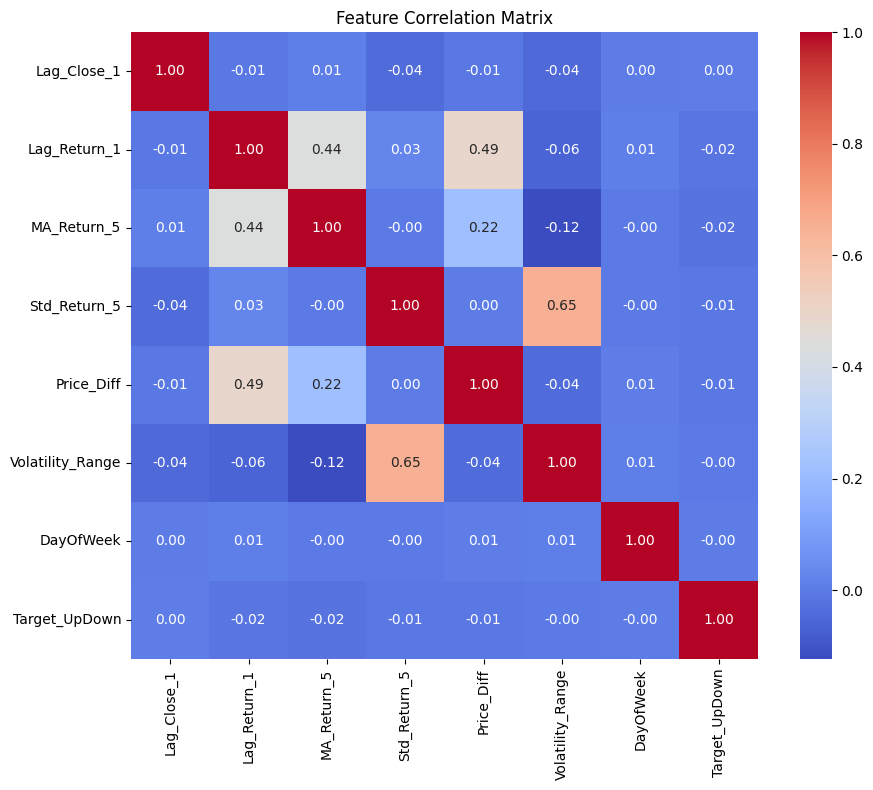


📊 Validation Accuracy: 0.5089
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.29      0.37     45059
           1       0.52      0.71      0.60     47487

    accuracy                           0.51     92546
   macro avg       0.50      0.50      0.48     92546
weighted avg       0.50      0.51      0.49     92546



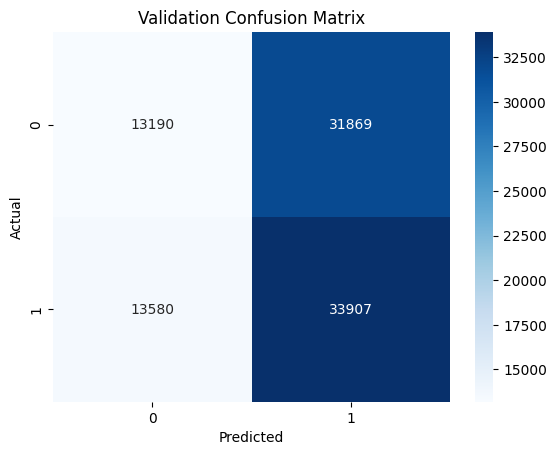


📊 Test Accuracy: 0.5146
Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.27      0.35     44435
           1       0.52      0.74      0.61     48111

    accuracy                           0.51     92546
   macro avg       0.51      0.51      0.48     92546
weighted avg       0.51      0.51      0.49     92546



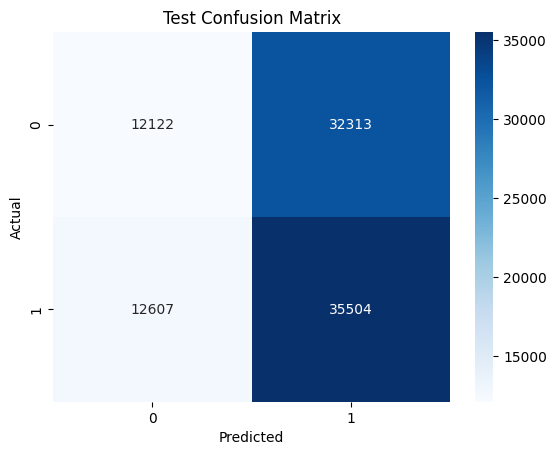

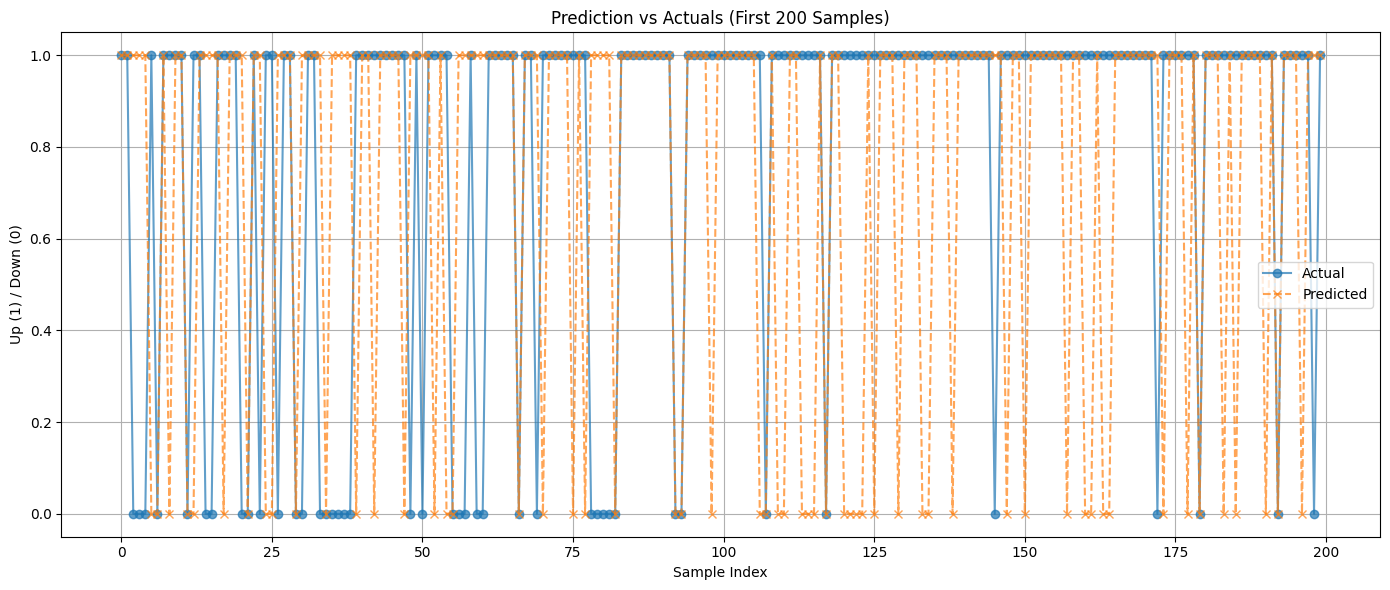

<Figure size 1000x600 with 0 Axes>

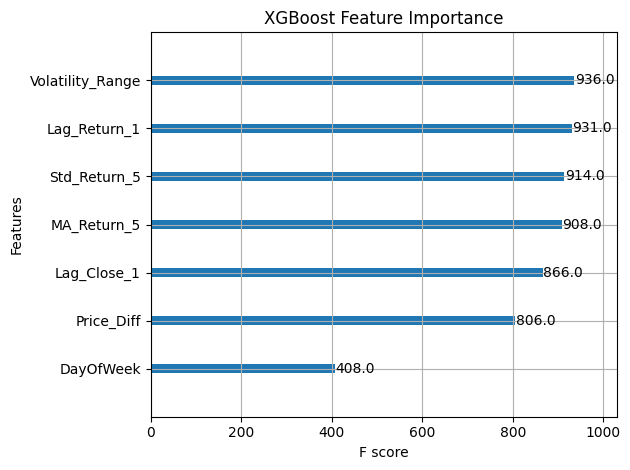

In [48]:

# ----------------------------------------
# 1. Feature Engineering Function
# ----------------------------------------
def prepare_features(df):
    df = df.sort_values(['Symbol', 'Date']).copy()

    df['Lag_Close_1'] = df.groupby('Symbol')['Close'].shift(1)
    df['Lag_Return_1'] = df.groupby('Symbol')['Close'].pct_change(1)
    df['MA_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).mean())
    df['Std_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).std())
    df['Price_Diff'] = df['Close'] - df['Open']
    df['Volatility_Range'] = (df['High'] - df['Low']) / df['Close']
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
    df['Target_UpDown'] = (df['Next_Close'] > df['Close']).astype(int)

    df = df.dropna(subset=[
        'Lag_Close_1', 'Lag_Return_1', 'MA_Return_5', 'Std_Return_5',
        'Price_Diff', 'Volatility_Range', 'DayOfWeek', 'Target_UpDown'
    ])

    return df


# ----------------------------------------
# 2. Split Chronologically
# ----------------------------------------
def split_data_chronologically(df, feature_cols, target_col, train_ratio=0.7, val_ratio=0.15):
    df = df.sort_values('Date').reset_index(drop=True)

    total_len = len(df)
    train_end = int(total_len * train_ratio)
    val_end = int(total_len * (train_ratio + val_ratio))

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    X_train, y_train = df_train[feature_cols], df_train[target_col]
    X_val, y_val = df_val[feature_cols], df_val[target_col]
    X_test, y_test = df_test[feature_cols], df_test[target_col]

    return X_train, y_train, X_val, y_val, X_test, y_test


# ----------------------------------------
# 3. Train XGBoost Classifier
# ----------------------------------------
def train_xgboost_classifier(X_train, y_train):
    model = XGBClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model


# ----------------------------------------
# 4. Evaluate & Visualize
# ----------------------------------------
def evaluate_and_plot(model, X, y_true, dataset_label, show_pred_plot=False):
    y_pred = model.predict(X)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n📊 {dataset_label} Accuracy: {acc:.4f}")
    print(f"{dataset_label} Classification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{dataset_label} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if show_pred_plot:
        plt.figure(figsize=(14, 6))
        plt.plot(y_true[:200].reset_index(drop=True), label='Actual', marker='o', linestyle='-', alpha=0.7)
        plt.plot(pd.Series(y_pred[:200]), label='Predicted', marker='x', linestyle='--', alpha=0.7)
        plt.title('Prediction vs Actuals (First 200 Samples)')
        plt.xlabel('Sample Index')
        plt.ylabel('Up (1) / Down (0)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# ----------------------------------------
# 5. Feature Importance Plot
# ----------------------------------------
def plot_model_feature_importance(model):
    plt.figure(figsize=(10, 6))
    plot_importance(model)
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()


# ----------------------------------------
# 6. Correlation Matrix
# ----------------------------------------
def plot_feature_correlation_matrix(df, feature_cols, target_col):
    corr_data = df[feature_cols + [target_col]].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

# Step 1: Feature Engineering
df_features = prepare_features(df_companies_and_stock)

# Step 2: Define Features & Target
FEATURE_COLS = [
    'Lag_Close_1', 'Lag_Return_1', 'MA_Return_5', 'Std_Return_5',
    'Price_Diff', 'Volatility_Range', 'DayOfWeek'
]
TARGET_COL = 'Target_UpDown'

# Step 3: Correlation Matrix
plot_feature_correlation_matrix(df_features, FEATURE_COLS, TARGET_COL)

# Step 4: Split
X_train, y_train, X_val, y_val, X_test, y_test = split_data_chronologically(
    df_features, FEATURE_COLS, TARGET_COL
)

# Step 5: Train & Evaluate
model = train_xgboost_classifier(X_train, y_train)
evaluate_and_plot(model, X_val, y_val, "Validation")
evaluate_and_plot(model, X_test, y_test, "Test", show_pred_plot=True)
plot_model_feature_importance(model)


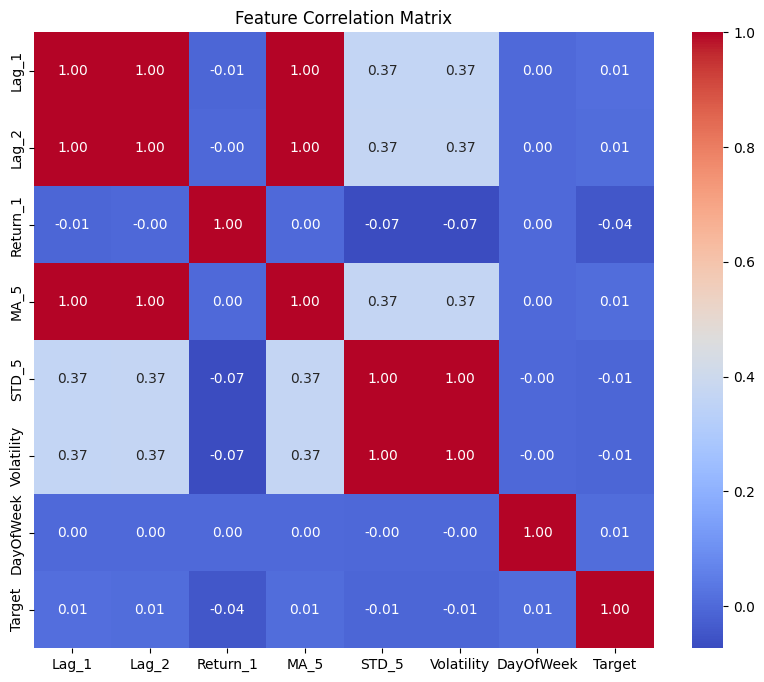


📊 Validation Accuracy: 0.4987
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.38      0.45       202
           1       0.47      0.64      0.54       175

    accuracy                           0.50       377
   macro avg       0.51      0.51      0.49       377
weighted avg       0.51      0.50      0.49       377


📊 Test Accuracy: 0.4615
Test Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.36      0.36       162
           1       0.53      0.54      0.53       215

    accuracy                           0.46       377
   macro avg       0.45      0.45      0.45       377
weighted avg       0.46      0.46      0.46       377



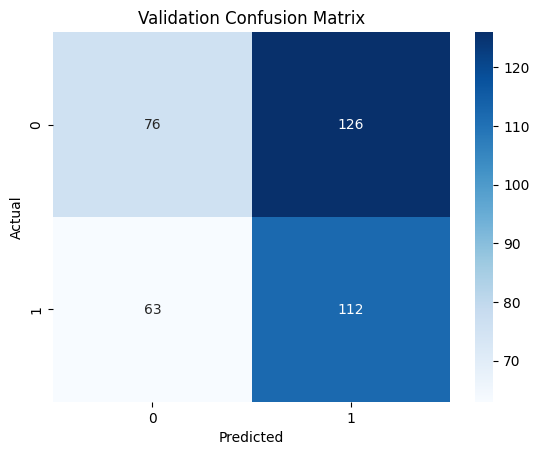

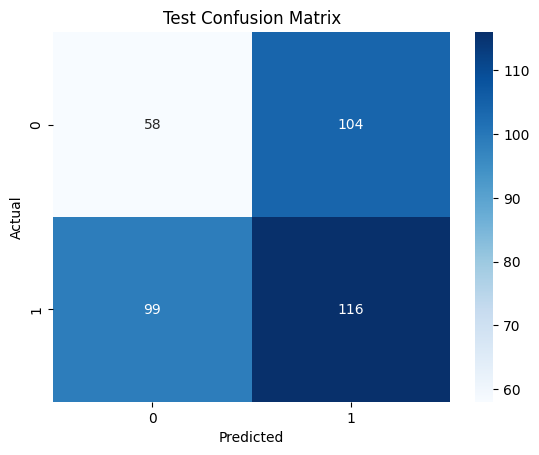

<Figure size 1000x600 with 0 Axes>

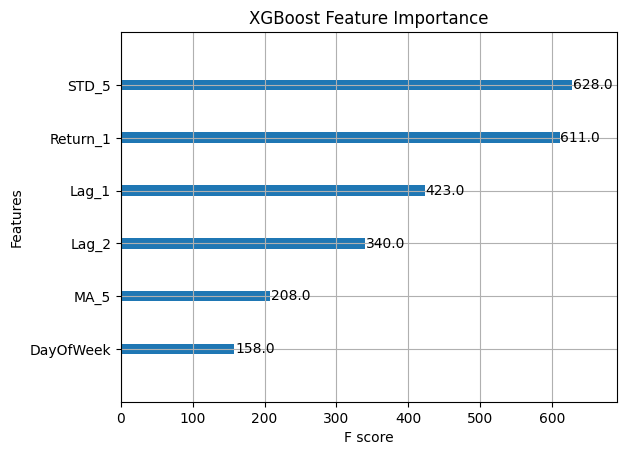

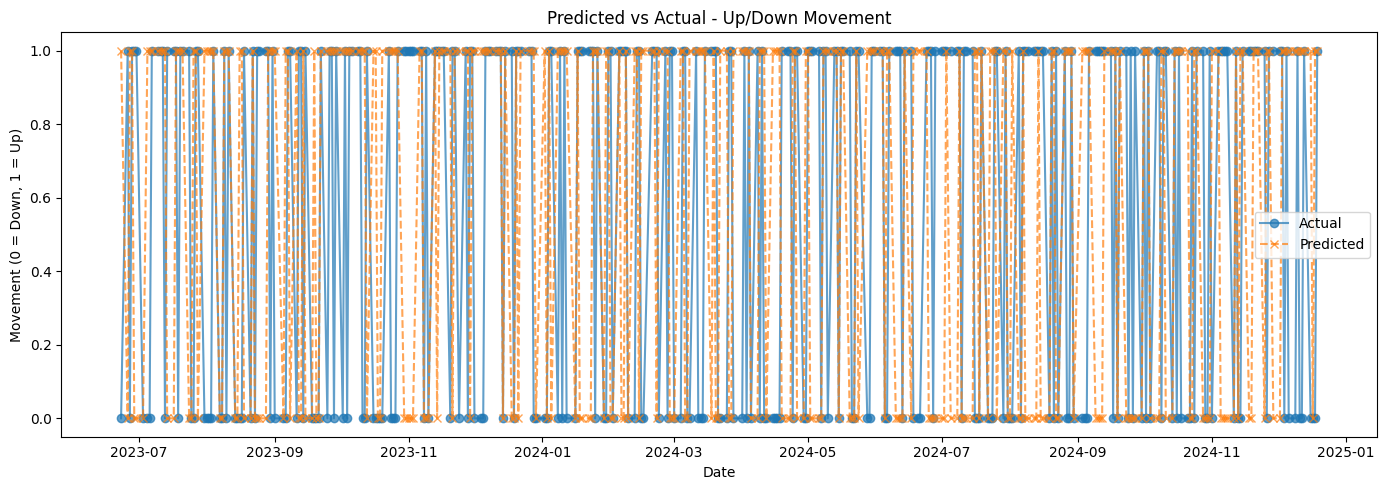

In [53]:


# -----------------------------------------------
# 1. Feature Engineering for S&P500 Index
# -----------------------------------------------
def prepare_index_classification_data(df):
    df = df.sort_values("Date").copy()

    df['Lag_1'] = df['S&P500'].shift(1)
    df['Lag_2'] = df['S&P500'].shift(2)
    df['Return_1'] = df['S&P500'].pct_change(1)
    df['MA_5'] = df['S&P500'].rolling(5).mean()
    df['STD_5'] = df['S&P500'].rolling(5).std()
    df['Volatility'] = df['STD_5']
    df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek

    df['Next'] = df['S&P500'].shift(-1)
    df['Target'] = (df['Next'] > df['S&P500']).astype(int)

    df = df.dropna().reset_index(drop=True)
    return df

# -----------------------------------------------
# 2. Split Data Chronologically
# -----------------------------------------------
def split_index_data(df):
    total_len = len(df)
    train_end = int(total_len * 0.7)
    val_end = int(total_len * 0.85)

    df_train = df.iloc[:train_end]
    df_val   = df.iloc[train_end:val_end]
    df_test  = df.iloc[val_end:]

    return df_train, df_val, df_test

# -----------------------------------------------
# 3. Train XGBoost Classifier
# -----------------------------------------------
def train_index_model(df_train, df_val, df_test):
    features = ['Lag_1', 'Lag_2', 'Return_1', 'MA_5', 'STD_5', 'Volatility', 'DayOfWeek']
    X_train, y_train = df_train[features], df_train['Target']
    X_val, y_val = df_val[features], df_val['Target']
    X_test, y_test = df_test[features], df_test['Target']

    model = XGBClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    return model, X_val, y_val, val_preds, X_test, y_test, test_preds, df_test

# -----------------------------------------------
# 4. Evaluation Function
# -----------------------------------------------
def evaluate_model(y_true, y_pred, label="Test"):
    print(f"\n📊 {label} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{label} Classification Report:")
    print(classification_report(y_true, y_pred))

# -----------------------------------------------
# 5. Plot Confusion Matrix
# -----------------------------------------------
def plot_confusion(y_true, y_pred, label="Test"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{label} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# -----------------------------------------------
# 6. Plot Correlation Matrix
# -----------------------------------------------
def plot_correlation_matrix(df):
    features = ['Lag_1', 'Lag_2', 'Return_1', 'MA_5', 'STD_5', 'Volatility', 'DayOfWeek', 'Target']
    corr = df[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Matrix")
    plt.show()

# -----------------------------------------------
# 7. Plot Feature Importance
# -----------------------------------------------
def plot_feature_importance(model):
    plt.figure(figsize=(10, 6))
    plot_importance(model, max_num_features=10)
    plt.title("XGBoost Feature Importance")
    plt.show()

# -----------------------------------------------
# 8. Plot Prediction vs Actual
# -----------------------------------------------
def plot_prediction_vs_actual(df_test, y_test, y_pred):
    df_plot = df_test.copy()
    df_plot['Actual'] = y_test
    df_plot['Predicted'] = y_pred
    df_plot['Date'] = pd.to_datetime(df_plot['Date'])

    plt.figure(figsize=(14, 5))
    plt.plot(df_plot['Date'], df_plot['Actual'], label='Actual', linestyle='-', marker='o', alpha=0.7)
    plt.plot(df_plot['Date'], df_plot['Predicted'], label='Predicted', linestyle='--', marker='x', alpha=0.7)
    plt.title("Predicted vs Actual - Up/Down Movement")
    plt.xlabel("Date")
    plt.ylabel("Movement (0 = Down, 1 = Up)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_sp500_index_classification():
    df = df_sp500_index.dropna(subset=["S&P500"])

    df_fe = prepare_index_classification_data(df)
    plot_correlation_matrix(df_fe)

    df_train, df_val, df_test = split_index_data(df_fe)
    model, X_val, y_val, val_preds, X_test, y_test, test_preds, df_test_final = train_index_model(df_train, df_val, df_test)

    evaluate_model(y_val, val_preds, label="Validation")
    evaluate_model(y_test, test_preds, label="Test")

    plot_confusion(y_val, val_preds, label="Validation")
    plot_confusion(y_test, test_preds, label="Test")
    plot_feature_importance(model)
    plot_prediction_vs_actual(df_test_final, y_test, test_preds)

# Example usage (disabled by request)
run_sp500_index_classification()


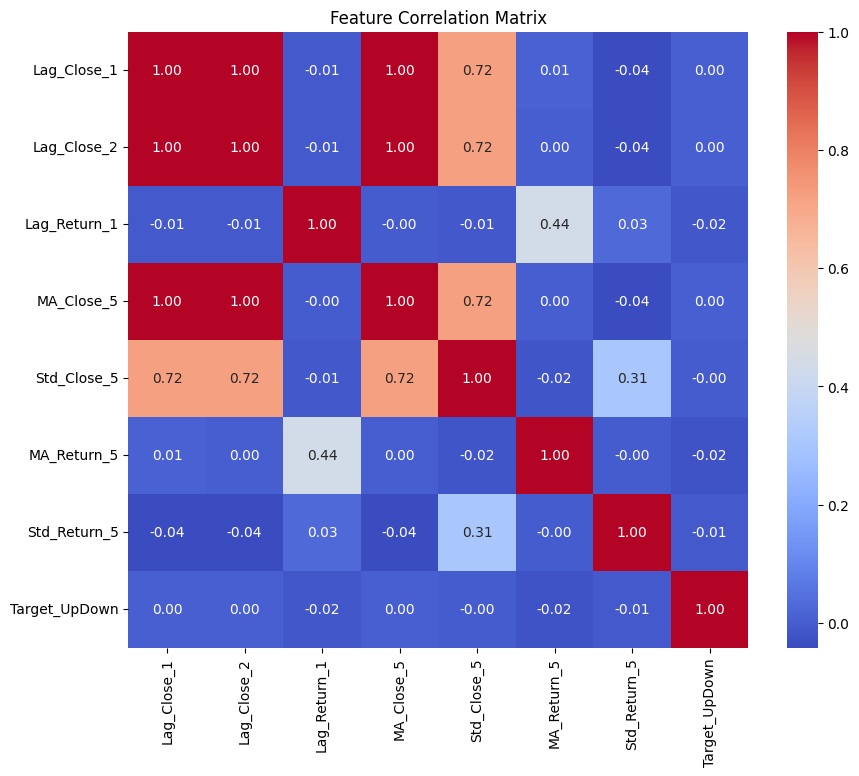

Validation Accuracy: 0.5095
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.24      0.32     44837
           1       0.52      0.76      0.62     47645

    accuracy                           0.51     92482
   macro avg       0.50      0.50      0.47     92482
weighted avg       0.50      0.51      0.47     92482


Test Accuracy: 0.5145
Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.23      0.31     44457
           1       0.52      0.78      0.63     48182

    accuracy                           0.51     92639
   macro avg       0.50      0.50      0.47     92639
weighted avg       0.51      0.51      0.47     92639



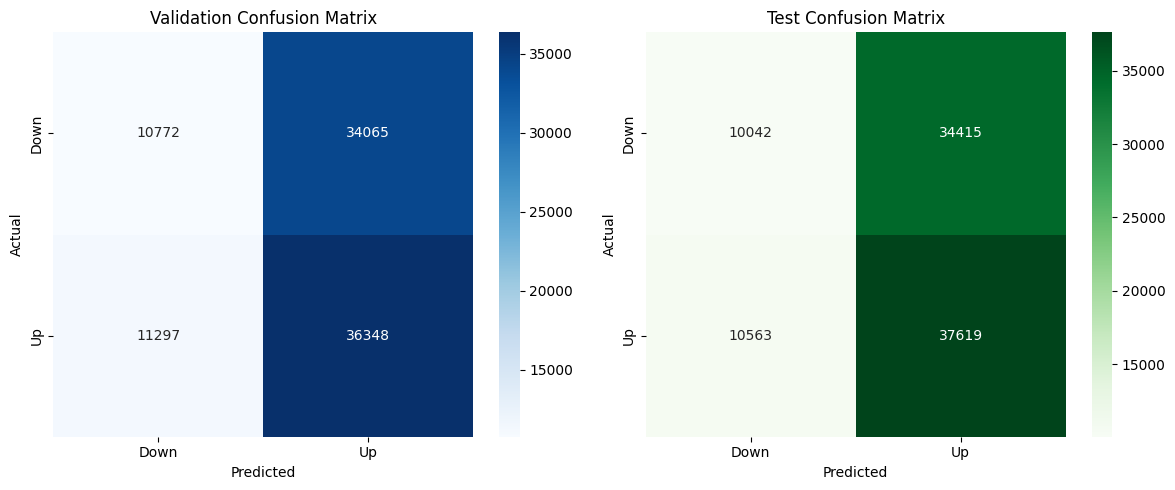


Validation AUC: 0.5028
Test AUC: 0.5066


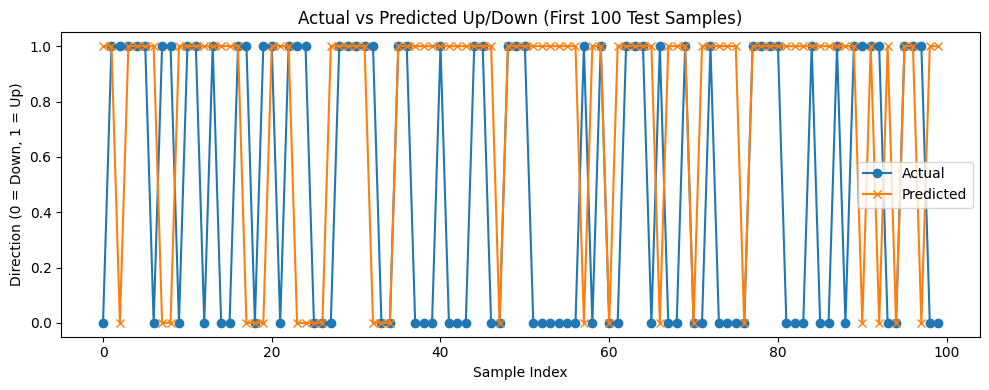

In [38]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1. Feature Engineering & Target Creation
# -----------------------------------------------
def prepare_classification_dataset_all(df):
    df = df.sort_values(['Symbol', 'Date']).copy()

    df['Lag_Close_1'] = df.groupby('Symbol')['Close'].shift(1)
    df['Lag_Close_2'] = df.groupby('Symbol')['Close'].shift(2)
    df['Lag_Return_1'] = df.groupby('Symbol')['Close'].pct_change(1)
    df['MA_Close_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(5).mean())
    df['Std_Close_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(5).std())
    df['MA_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).mean())
    df['Std_Return_5'] = df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change().rolling(5).std())
    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
    df['Target_UpDown'] = (df['Next_Close'] > df['Close']).astype(int)

    df = df.dropna(subset=[
        'Lag_Close_1', 'Lag_Close_2', 'Lag_Return_1',
        'MA_Close_5', 'Std_Close_5', 'MA_Return_5', 'Std_Return_5', 'Target_UpDown'
    ])

    return df

# -----------------------------------------------
# 2. Time Series Split For All Symbols
# -----------------------------------------------
def split_all_symbols(df):
    df_train_list, df_val_list, df_test_list = [], [], []

    for symbol, group in df.groupby('Symbol'):
        group_sorted = group.sort_values('Date')
        total_len = len(group_sorted)
        if total_len < 100:
            continue

        train_end = int(total_len * 0.7)
        val_end = int(total_len * 0.85)

        df_train_list.append(group_sorted.iloc[:train_end])
        df_val_list.append(group_sorted.iloc[train_end:val_end])
        df_test_list.append(group_sorted.iloc[val_end:])

    df_train = pd.concat(df_train_list)
    df_val = pd.concat(df_val_list)
    df_test = pd.concat(df_test_list)

    return df_train, df_val, df_test

# -----------------------------------------------
# 3. Train XGBoost Classifier
# -----------------------------------------------
def train_classifier_all(df_train, df_val, df_test):
    features = [
        'Lag_Close_1', 'Lag_Close_2', 'Lag_Return_1',
        'MA_Close_5', 'Std_Close_5', 'MA_Return_5', 'Std_Return_5'
    ]
    target = 'Target_UpDown'

    X_train, y_train = df_train[features], df_train[target]
    X_val, y_val = df_val[features], df_val[target]
    X_test, y_test = df_test[features], df_test[target]

    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    model.fit(X_train, y_train)

    return model, X_train, y_train, X_val, y_val, X_test, y_test

# -----------------------------------------------
# 4. Evaluation & Visualization
# -----------------------------------------------
def evaluate_classifier_all(model, X_val, y_val, X_test, y_test):
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"Validation Accuracy: {val_acc:.4f}")
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    print(f"\nTest Accuracy: {test_acc:.4f}")
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrices
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
    plt.title('Validation Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(1, 2, 2)
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
    plt.title('Test Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.tight_layout()
    plt.show()

    try:
        val_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
        test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"\nValidation AUC: {val_auc:.4f}")
        print(f"Test AUC: {test_auc:.4f}")
    except:
        print("AUC computation skipped.")

    # Actual vs Predicted Plot (Test Set)
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values[:100], label="Actual", marker='o')
    plt.plot(y_test_pred[:100], label="Predicted", marker='x')
    plt.title("Actual vs Predicted Up/Down (First 100 Test Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Direction (0 = Down, 1 = Up)")
    plt.legend()
    plt.tight_layout()
    plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_correlation(df, features):
    plt.figure(figsize=(10, 8))
    corr_matrix = df[features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Matrix")
    plt.show()


# -----------------------------------------------
# 5. Run Full Pipeline
# -----------------------------------------------
def run_updown_pipeline_all(df):
    df = prepare_classification_dataset_all(df)
    classification_features = [
        'Lag_Close_1', 'Lag_Close_2', 'Lag_Return_1',
        'MA_Close_5', 'Std_Close_5', 'MA_Return_5', 'Std_Return_5'
    ]
    plot_feature_correlation(df, classification_features + ['Target_UpDown'])
    df_train, df_val, df_test = split_all_symbols(df)
    model, X_train, y_train, X_val, y_val, X_test, y_test = train_classifier_all(df_train, df_val, df_test)
    evaluate_classifier_all(model, X_val, y_val, X_test, y_test)

run_updown_pipeline_all(df_companies_and_stock)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor, plot_importance
from prophet import Prophet

# -------------------------
# Forecasting Visualizations
# -------------------------
def plot_forecast(y_true, y_pred, title="Forecast vs Actual"):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label="Actual", marker='o', linewidth=2)
    plt.plot(y_pred, label="Predicted", marker='x', linestyle='--')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = np.array(y_true) - np.array(y_pred)
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title("Residuals Histogram")
    plt.xlabel("Error (y_true - y_pred)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_rolling_errors(y_true, y_pred, window=10):
    errors = np.abs(np.array(y_true) - np.array(y_pred))
    rolling_mae = pd.Series(errors).rolling(window=window).mean()
    plt.figure(figsize=(10, 5))
    plt.plot(rolling_mae, label=f"Rolling MAE (window={window})", color='orange')
    plt.title("Rolling MAE Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_forecasting_results(y_true, y_pred, model_name="Model"):
    print(f"\n📊 Visualizing results for {model_name}")
    plot_forecast(y_true, y_pred, title=f"{model_name} - Forecast vs Actual")
    plot_residuals(y_true, y_pred)
    plot_rolling_errors(y_true, y_pred)

def show_feature_importance(model, max_num_features=10):
    plt.figure(figsize=(10, 6))
    plot_importance(model, max_num_features=max_num_features, importance_type='weight')
    plt.title("Feature Importance (XGBoost)")
    plt.grid(True)
    plt.show()

# -------------------------
# 1. Data Preparation with Feature Engineering
# -------------------------
def prepare_forecasting_splits(df, symbol, forecast_column='Close'):
    print("Splitting data.")
    df_symbol = df[df['Symbol'] == symbol].sort_values('Date').copy()

    # Feature Engineering
    df_symbol['Lag_Close_1'] = df_symbol[forecast_column].shift(1)
    df_symbol['Lag_Close_2'] = df_symbol[forecast_column].shift(2)
    df_symbol['MA_Close_3'] = df_symbol[forecast_column].rolling(3).mean()
    df_symbol['MA_Close_5'] = df_symbol[forecast_column].rolling(5).mean()
    df_symbol['MA_Close_10'] = df_symbol[forecast_column].rolling(10).mean()

    df_symbol = df_symbol.dropna().reset_index(drop=True)

    total_len = len(df_symbol)
    train_end = int(total_len * 0.7)
    val_end = int(total_len * 0.85)

    df_train = df_symbol.iloc[:train_end]
    df_val   = df_symbol.iloc[train_end:val_end]
    df_test  = df_symbol.iloc[val_end:]

    return df_train, df_val, df_test

# -------------------------
# 2. Train Prophet
# -------------------------
def train_prophet_with_splits(df_train, df_val, df_test, forecast_column='Close'):
    print("training for prophet.")
    df_train_p = df_train[['Date', forecast_column]].rename(columns={'Date': 'ds', forecast_column: 'y'})
    df_val_p   = df_val[['Date', forecast_column]].rename(columns={'Date': 'ds', forecast_column: 'y'})
    df_test_p  = df_test[['Date', forecast_column]].rename(columns={'Date': 'ds', forecast_column: 'y'})

    model = Prophet(daily_seasonality=True)
    model.fit(df_train_p)

    future_val = df_val_p[['ds']]
    future_test = df_test_p[['ds']]

    val_forecast = model.predict(future_val)
    test_forecast = model.predict(future_test)

    return {
        'model': model,
        'val_actuals': df_val_p['y'].values,
        'val_preds': val_forecast['yhat'].values,
        'test_actuals': df_test_p['y'].values,
        'test_preds': test_forecast['yhat'].values
    }

# -------------------------
# 3. Train XGBoost
# -------------------------
def train_xgboost_with_splits(df_train, df_val, df_test, forecast_column='Close'):
    print("training for xgboost.")
    features = ['Lag_Close_1', 'Lag_Close_2', 'MA_Close_3', 'MA_Close_5', 'MA_Close_10']

    X_train, y_train = df_train[features], df_train[forecast_column]
    X_val, y_val     = df_val[features], df_val[forecast_column]
    X_test, y_test   = df_test[features], df_test[forecast_column]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    return {
        'model': model,
        'val_actuals': y_val.values,
        'val_preds': model.predict(X_val),
        'test_actuals': y_test.values,
        'test_preds': model.predict(X_test)
    }

# -------------------------
# 4. Evaluation
# -------------------------
def evaluate_model_results(actuals, preds, model_name, dataset_label):
    print("Eval result.")
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    print(f"{model_name} [{dataset_label}] - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return {'MAE': mae, 'RMSE': rmse}

# -------------------------
# 5. Run Forecasting for a Symbol
# -------------------------
def run_forecasting_for_symbol_with_splits(df, symbol, forecast_column='Close'):
    df_train, df_val, df_test = prepare_forecasting_splits(df, symbol, forecast_column)

    if len(df_train) < 30:
        print(f"⚠️ Skipping {symbol}, not enough training data")
        return None

    print(f"\n🔍 Running forecasting for: {symbol}")

    try:
        result_p = train_prophet_with_splits(df_train, df_val, df_test, forecast_column)
        evaluate_model_results(result_p['val_actuals'], result_p['val_preds'], 'Prophet', 'Validation')
        evaluate_model_results(result_p['test_actuals'], result_p['test_preds'], 'Prophet', 'Test')
        visualize_forecasting_results(result_p['test_actuals'], result_p['test_preds'], model_name="Prophet")
    except Exception as e:
        print(f"❌ Prophet error for {symbol}: {e}")

    try:
        result_xgb = train_xgboost_with_splits(df_train, df_val, df_test, forecast_column)
        evaluate_model_results(result_xgb['val_actuals'], result_xgb['val_preds'], 'XGBoost', 'Validation')
        evaluate_model_results(result_xgb['test_actuals'], result_xgb['test_preds'], 'XGBoost', 'Test')
        visualize_forecasting_results(result_xgb['test_actuals'], result_xgb['test_preds'], model_name="XGBoost")
        show_feature_importance(result_xgb['model'])
    except Exception as e:
        print(f"❌ XGBoost error for {symbol}: {e}")

# -------------------------
# 6. Run for All Symbols
# -------------------------
def run_forecasting_for_all_symbols(df, forecast_column='Close'):
    symbols = df['Symbol'].unique()
    for symbol in symbols:
        run_forecasting_for_symbol_with_splits(df, symbol, forecast_column)

run_forecasting_for_all_symbols(df_companies_and_stock, forecast_column='Close')



🔍 Running enhanced XGBoost forecasting for: AOS
XGBoost [Validation] - MAE: 3.3160, RMSE: 5.9018
XGBoost [Test] - MAE: 9.0614, RMSE: 11.7320


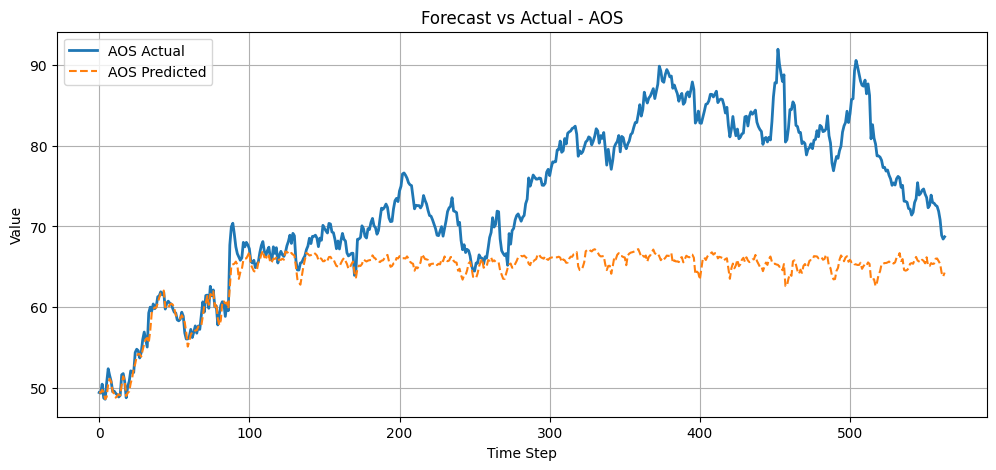

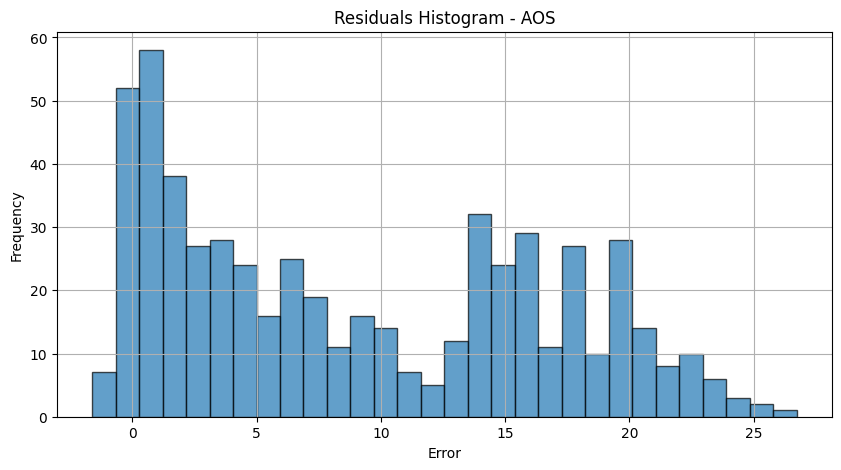

<Figure size 1000x600 with 0 Axes>

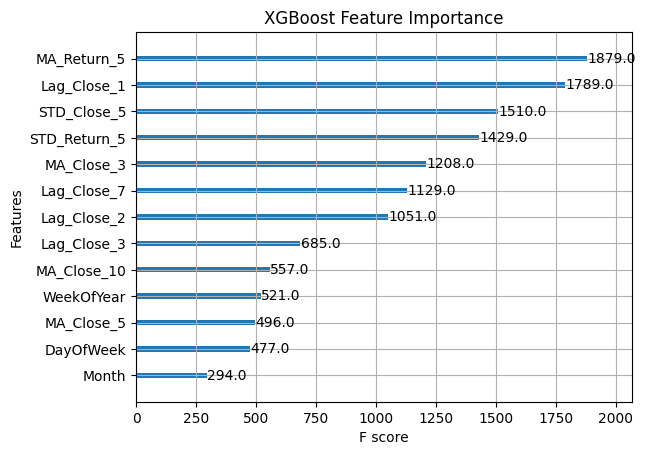


🔍 Running enhanced XGBoost forecasting for: ABT
XGBoost [Validation] - MAE: 23.1982, RMSE: 25.0920
XGBoost [Test] - MAE: 14.8242, RMSE: 16.1270


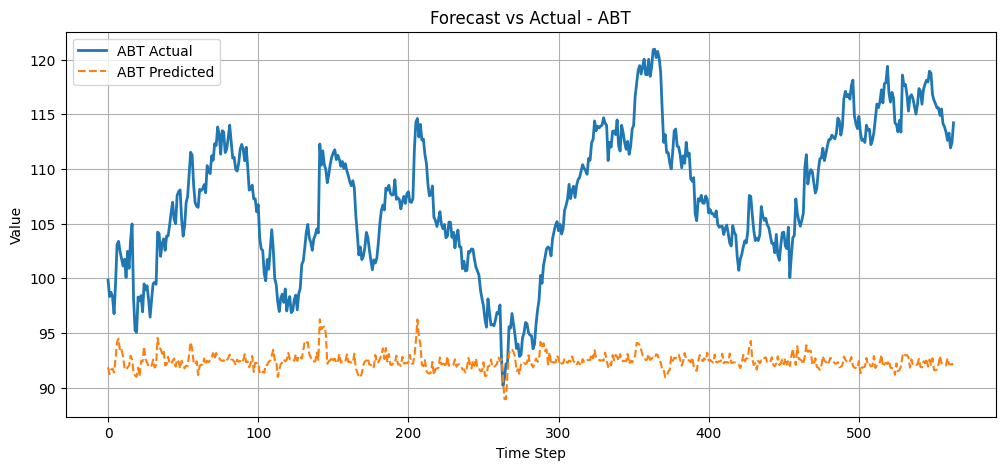

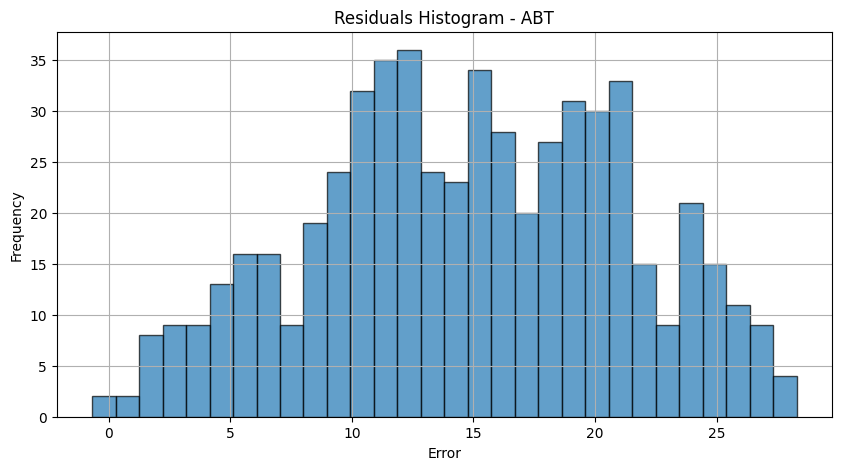

<Figure size 1000x600 with 0 Axes>

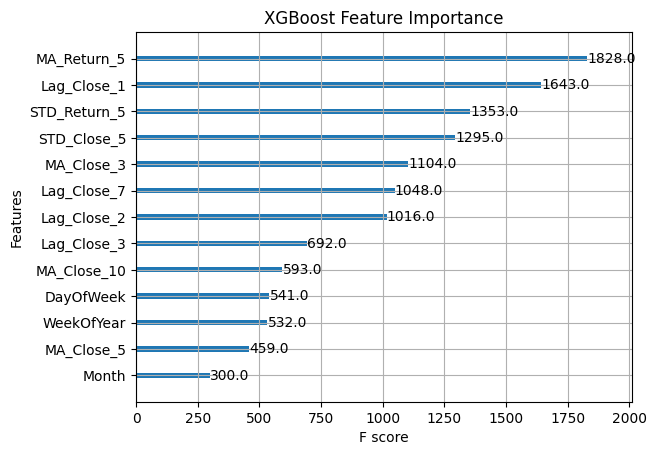


🔍 Running enhanced XGBoost forecasting for: ABBV
XGBoost [Validation] - MAE: 21.7489, RMSE: 26.9915
XGBoost [Test] - MAE: 46.4548, RMSE: 49.9017


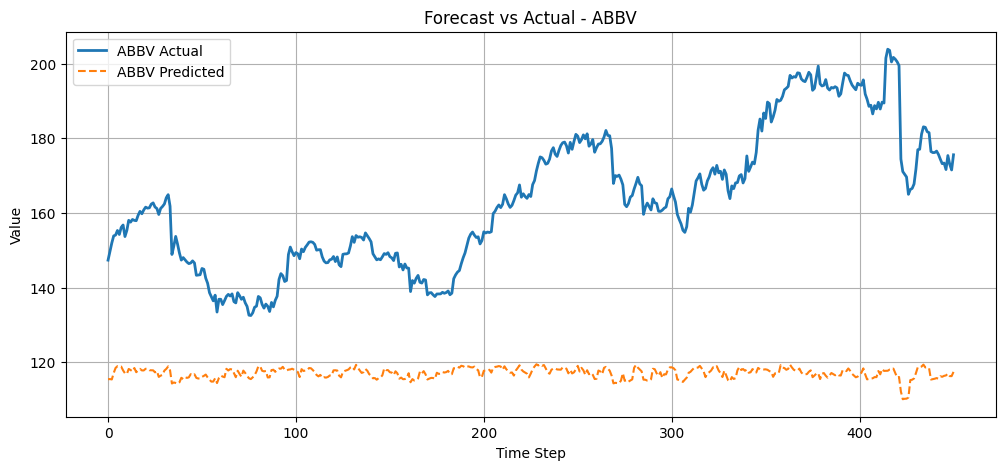

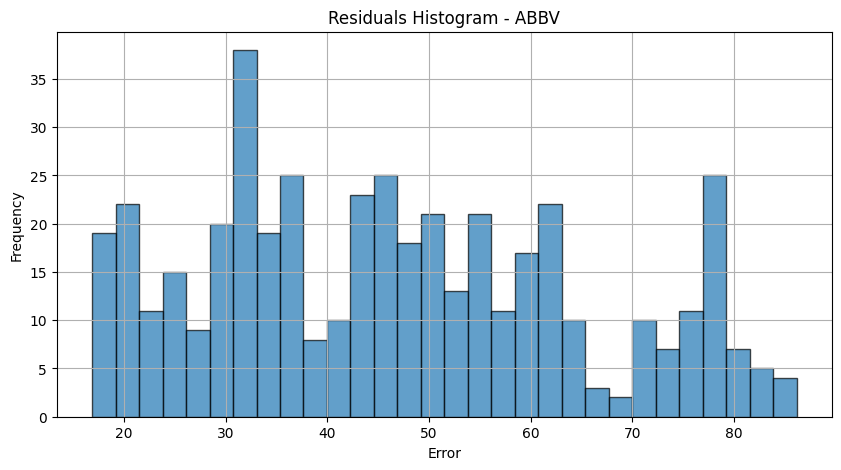

<Figure size 1000x600 with 0 Axes>

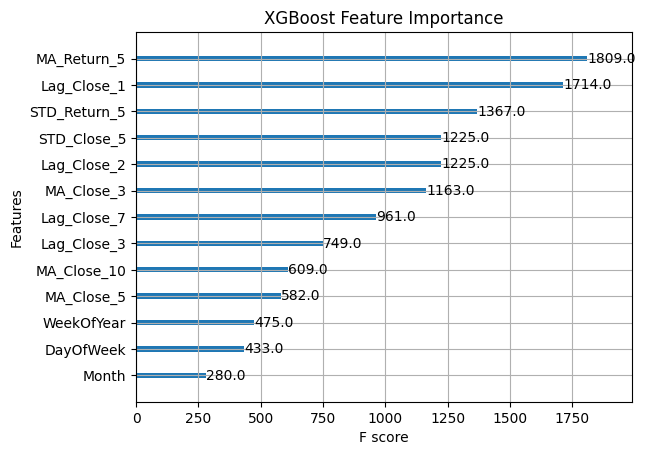


🔍 Running enhanced XGBoost forecasting for: AES
XGBoost [Validation] - MAE: 3.1087, RMSE: 3.9056
XGBoost [Test] - MAE: 1.6894, RMSE: 3.0063


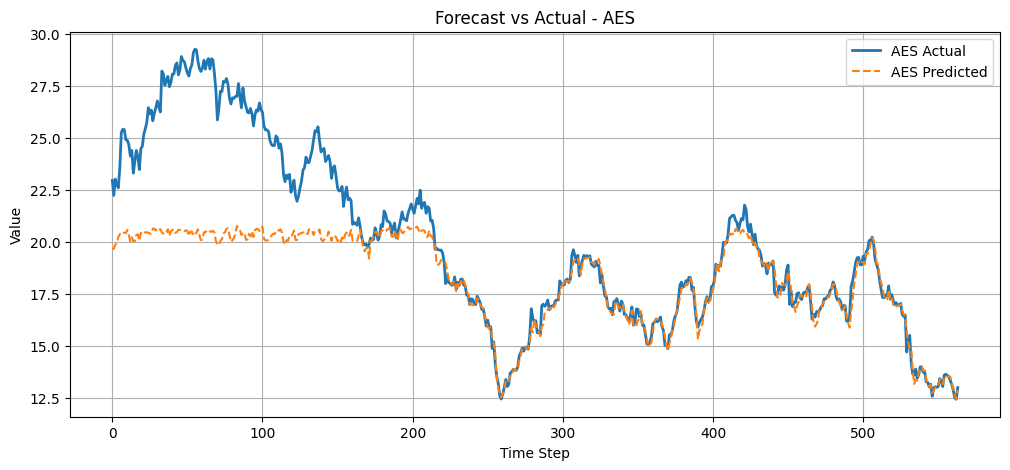

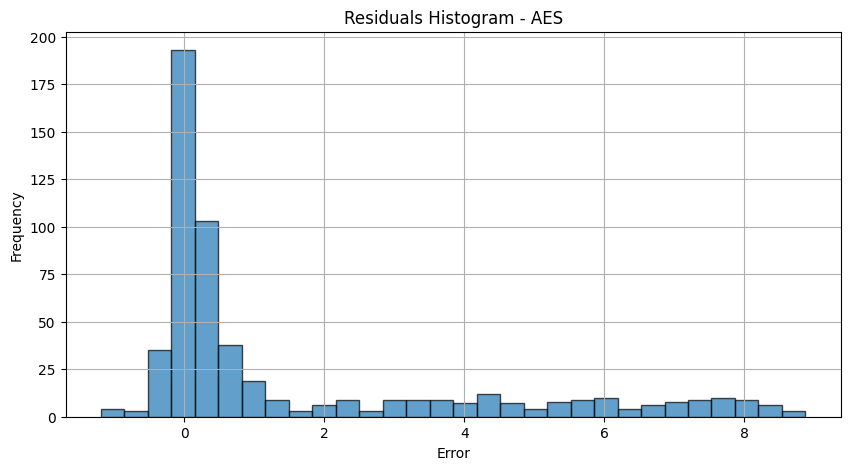

<Figure size 1000x600 with 0 Axes>

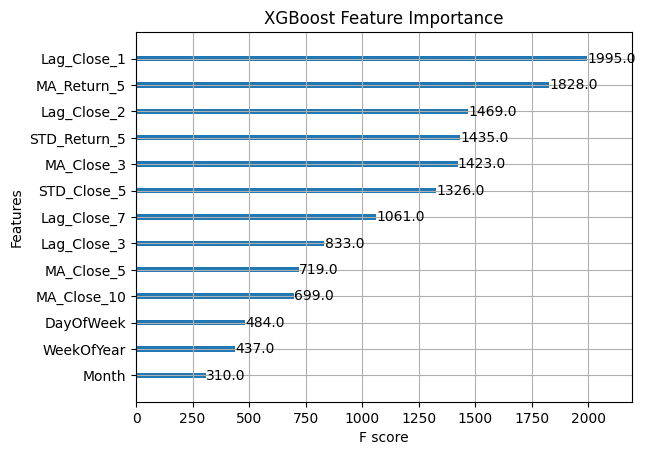


🔍 Running enhanced XGBoost forecasting for: ALB
XGBoost [Validation] - MAE: 55.7634, RMSE: 72.0040
XGBoost [Test] - MAE: 43.5782, RMSE: 66.4875


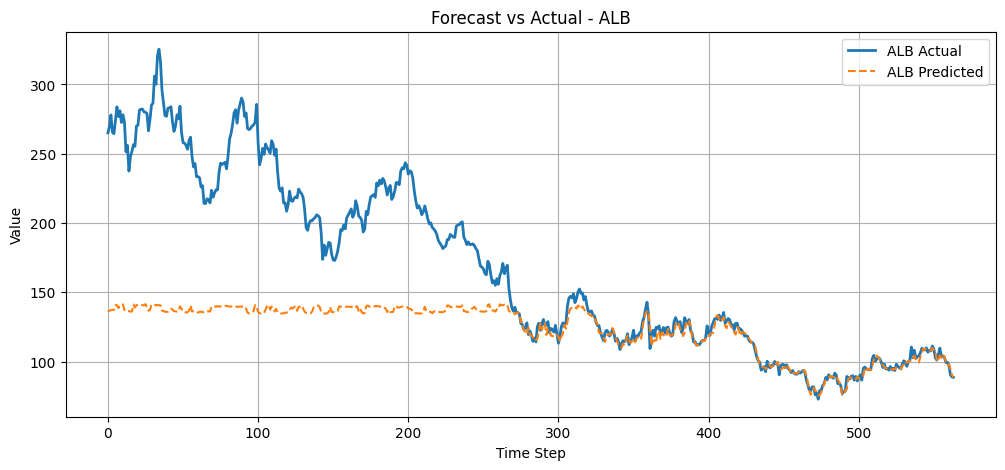

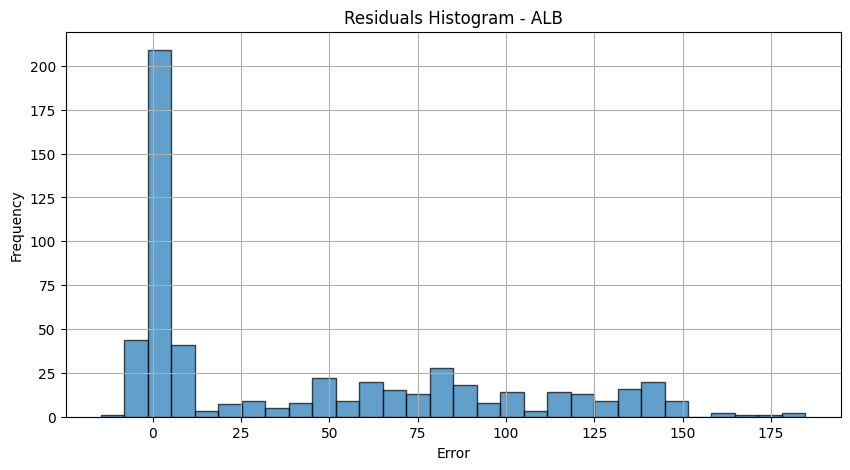

<Figure size 1000x600 with 0 Axes>

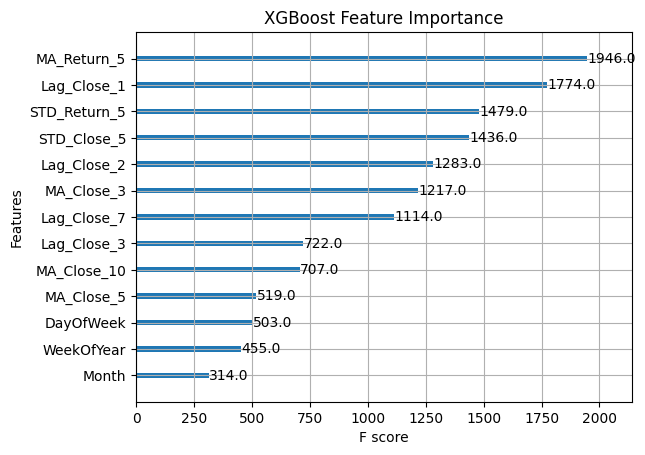


🔍 Running enhanced XGBoost forecasting for: ALLE


c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [32]:
def engineer_features(df, forecast_column='Close'):
    df = df.copy()
    df = df.sort_values(['Symbol', 'Date'])

    df['Lag_Close_1'] = df.groupby('Symbol')[forecast_column].shift(1)
    df['Lag_Close_2'] = df.groupby('Symbol')[forecast_column].shift(2)
    df['Lag_Close_3'] = df.groupby('Symbol')[forecast_column].shift(3)
    df['Lag_Close_7'] = df.groupby('Symbol')[forecast_column].shift(7)

    df['MA_Close_3'] = df.groupby('Symbol')[forecast_column].transform(lambda x: x.rolling(3).mean())
    df['MA_Close_5'] = df.groupby('Symbol')[forecast_column].transform(lambda x: x.rolling(5).mean())
    df['MA_Close_10'] = df.groupby('Symbol')[forecast_column].transform(lambda x: x.rolling(10).mean())
    df['STD_Close_5'] = df.groupby('Symbol')[forecast_column].transform(lambda x: x.rolling(5).std())

    df['Return'] = df.groupby('Symbol')[forecast_column].pct_change()
    df['MA_Return_5'] = df.groupby('Symbol')['Return'].transform(lambda x: x.rolling(5).mean())
    df['STD_Return_5'] = df.groupby('Symbol')['Return'].transform(lambda x: x.rolling(5).std())

    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week

    df = df.dropna()
    return df

# ------------------------------------------
# 2. Chronological Split
# ------------------------------------------
def split_time_series(df_symbol):
    df_symbol = df_symbol.sort_values('Date')  # Ensure chronological order
    total_len = len(df_symbol)
    train_end = int(total_len * 0.7)
    val_end = int(total_len * 0.85)

    df_train = df_symbol.iloc[:train_end]
    df_val   = df_symbol.iloc[train_end:val_end]
    df_test  = df_symbol.iloc[val_end:]

    return df_train, df_val, df_test

# ------------------------------------------
# 3. Train XGBoost Model
# ------------------------------------------
def train_advanced_xgboost(df_train, df_val, df_test, forecast_column='Close'):
    features = [
        'Lag_Close_1', 'Lag_Close_2', 'Lag_Close_3', 'Lag_Close_7',
        'MA_Close_3', 'MA_Close_5', 'MA_Close_10', 'STD_Close_5',
        'MA_Return_5', 'STD_Return_5',
        'DayOfWeek', 'Month', 'WeekOfYear'
    ]

    X_train, y_train = df_train[features], df_train[forecast_column]
    X_val, y_val     = df_val[features], df_val[forecast_column]
    X_test, y_test   = df_test[features], df_test[forecast_column]

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    return {
        'model': model,
        'val_actuals': y_val.values,
        'val_preds': model.predict(X_val),
        'test_actuals': y_test.values,
        'test_preds': model.predict(X_test)
    }

# ------------------------------------------
# 4. Evaluation + Visualization
# ------------------------------------------
def evaluate_forecast(y_true, y_pred, model_name="Model", dataset_label="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} [{dataset_label}] - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return {'MAE': mae, 'RMSE': rmse}

def plot_forecast(y_true, y_pred, symbol, title="Forecast vs Actual"):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label=f"{symbol} Actual", linewidth=2)
    plt.plot(y_pred, label=f"{symbol} Predicted", linestyle='--')
    plt.title(f"{title} - {symbol}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred, symbol):
    residuals = np.array(y_true) - np.array(y_pred)
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"Residuals Histogram - {symbol}")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_feature_importance(model):
    plt.figure(figsize=(10, 6))
    plot_importance(model, max_num_features=15)
    plt.title("XGBoost Feature Importance")
    plt.grid(True)
    plt.show()

# ------------------------------------------
# 5. Run For One Symbol
# ------------------------------------------
def run_symbol_forecasting_pipeline(df, symbol, forecast_column='Close'):
    print(f"\n🔍 Running enhanced XGBoost forecasting for: {symbol}")
    df_symbol = df[df['Symbol'] == symbol].copy()
    if len(df_symbol) < 100:
        print(f"⚠️ Not enough data for {symbol}")
        return

    df_symbol = engineer_features(df_symbol, forecast_column)
    df_train, df_val, df_test = split_time_series(df_symbol)

    result = train_advanced_xgboost(df_train, df_val, df_test, forecast_column)
    evaluate_forecast(result['val_actuals'], result['val_preds'], "XGBoost", "Validation")
    evaluate_forecast(result['test_actuals'], result['test_preds'], "XGBoost", "Test")

    plot_forecast(result['test_actuals'], result['test_preds'], symbol)
    plot_residuals(result['test_actuals'], result['test_preds'], symbol)
    plot_feature_importance(result['model'])

# ------------------------------------------
# 6. Run For All Symbols (Optional)
# ------------------------------------------
def run_all_symbols(df, forecast_column='Close'):
    for symbol in df['Symbol'].unique():
        run_symbol_forecasting_pipeline(df, symbol, forecast_column)

run_all_symbols(df_companies_and_stock, forecast_column='Close')


In [16]:
def add_stock_targets(df, volatility=5):
    df = df.sort_values(['Symbol', 'Date']).copy()
    
    # Calculate next day's close and return
    df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
    df['Target_UpDown'] = (df['Next_Close'] > df['Close']).astype(int)
    df['Target_Return'] = (df['Next_Close'] - df['Close']) / df['Close']

    # Calculate rolling volatility (standard deviation of returns)
    df['Return'] = df.groupby('Symbol')['Close'].pct_change()
    df['Target_Volatility'] = df.groupby('Symbol')['Return'].rolling(window=volatility).std().reset_index(0, drop=True)

    # Drop rows with NaNs caused by shifting or rolling
    df = df.dropna(subset=['Target_UpDown', 'Target_Return', 'Target_Volatility'])

    return df

df_companies_and_stock = add_stock_targets(df_companies_and_stock, 2)
row_count = df_companies_and_stock.shape[0]
print("df_companies_and_stock Row count:", row_count)

df_companies_and_stock Row count: 617315


In [54]:
row_count = df_sp500_stocks.shape[0]
print("df_sp500_stocks Row count:", row_count)

row_count = df_sp500_companies.shape[0]
print("df_sp500_companies Row count:", row_count)

row_count = df_companies_and_stock.shape[0]
print("df_companies_and_stock Row count:", row_count)
print(df_companies_and_stock.columns.tolist())



df_sp500_stocks Row count: 617831
df_sp500_companies Row count: 502
df_companies_and_stock Row count: 615767
['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Exchange', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight', 'Next_Close', 'Target_UpDown', 'Target_Return', 'Return', 'Target_Volatility']


In [55]:
from sklearn.model_selection import train_test_split

def split_dataset(df, stratify_col=None, test_size=0.3, val_size=0.5, random_state=42):
    stratify_vals = df[stratify_col] if stratify_col else None

    df_train, df_temp = train_test_split(df, test_size=test_size, stratify=stratify_vals, random_state=random_state)

    stratify_temp = df_temp[stratify_col] if stratify_col else None
    df_val, df_test = train_test_split(df_temp, test_size=val_size, stratify=stratify_temp, random_state=random_state)

    print(f"Train: {df_train.shape[0]} rows")
    print(f"Validation: {df_val.shape[0]} rows")
    print(f"Test: {df_test.shape[0]} rows")

    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)
df_train, df_validate, df_test = split_dataset(df_companies_and_stock, stratify_col='Symbol')

 

Train: 431036 rows
Validation: 92365 rows
Test: 92366 rows


Train Accuracy: 0.9997401609146336
Test Accuracy: 0.5002923153541347

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.48      0.48     44188
           1       0.52      0.52      0.52     48178

    accuracy                           0.50     92366
   macro avg       0.50      0.50      0.50     92366
weighted avg       0.50      0.50      0.50     92366



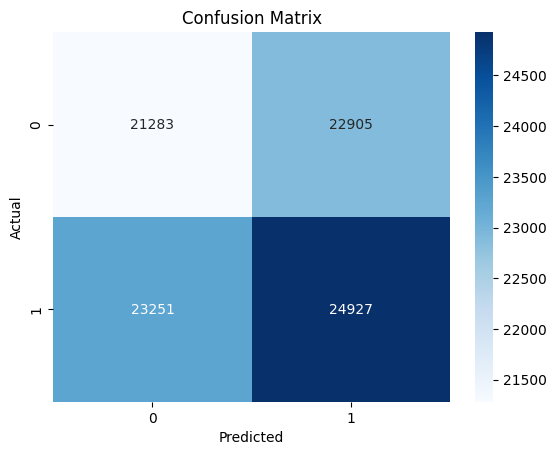

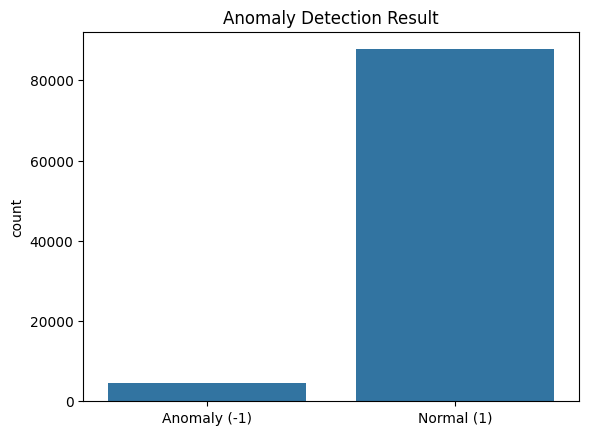

Detected Anomalies: 4649
Detected Normals: 87717


In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(df, features, target=None):
    X = df[features]
    y = df[target] if target else None
    return X, y

def train_classifier(X_train, y_train):
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    return clf

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def train_anomaly_detector(X_train):
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X_train)
    return model

def evaluate_anomaly_detector(model, X_test):
    preds = model.predict(X_test)  # 1 = normal, -1 = anomaly
    sns.countplot(x=preds)
    plt.title("Anomaly Detection Result")
    plt.xticks([0, 1], ['Anomaly (-1)', 'Normal (1)'])
    plt.show()

    print("Detected Anomalies:", (preds == -1).sum())
    print("Detected Normals:", (preds == 1).sum())


def run_classification(df_train, df_test, features, target):
    X_train, y_train = prepare_data(df_train, features, target)
    X_test, y_test = prepare_data(df_test, features, target)

    clf = train_classifier(X_train, y_train)
    evaluate_classifier(clf, X_train, y_train, X_test, y_test)

def run_anomaly(df_train, df_test, features):
    X_train, _ = prepare_data(df_train, features)
    X_test, _ = prepare_data(df_test, features)

    model = train_anomaly_detector(X_train)
    evaluate_anomaly_detector(model, X_test)

classification_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Weight']
classification_target = 'Target_UpDown'
anomaly_features = ['Return', 'Target_Volatility', 'Volume']
run_classification(df_train, df_test, classification_features, classification_target)
run_anomaly(df_train, df_test, anomaly_features)

In [60]:
def add_lag_features(df, lag_days=[1, 2]):
    for lag in lag_days:
        df[f'Lag_Close_{lag}'] = df.groupby('Symbol')['Close'].shift(lag)
        df[f'Lag_Volume_{lag}'] = df.groupby('Symbol')['Volume'].shift(lag)
        df[f'Lag_Return_{lag}'] = df.groupby('Symbol')['Return'].shift(lag)
    return df

def add_rolling_features(df, windows=[3, 5, 10]):
    for win in windows:
        df[f'MA_Close_{win}'] = df.groupby('Symbol')['Close'].rolling(win).mean().reset_index(0, drop=True)
        df[f'Std_Close_{win}'] = df.groupby('Symbol')['Close'].rolling(win).std().reset_index(0, drop=True)

        df[f'MA_Volume_{win}'] = df.groupby('Symbol')['Volume'].rolling(win).mean().reset_index(0, drop=True)
        df[f'Std_Volume_{win}'] = df.groupby('Symbol')['Volume'].rolling(win).std().reset_index(0, drop=True)

        df[f'MA_Return_{win}'] = df.groupby('Symbol')['Return'].rolling(win).mean().reset_index(0, drop=True)
        df[f'Std_Return_{win}'] = df.groupby('Symbol')['Return'].rolling(win).std().reset_index(0, drop=True)
    return df

add_lag_features_copy_1 = add_lag_features(df_companies_and_stock.copy())
add_lag_features_copy_1 = add_rolling_features(add_lag_features_copy_1)
df_train_copy_1, df_validate_copy_1, df_test_copy_1 = split_dataset(add_lag_features_copy_1, stratify_col='Symbol')


Train: 431036 rows
Validation: 92365 rows
Test: 92366 rows


Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Exchange', 'Shortname', 'Longname', 'Sector', 'Industry',
       'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State',
       'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight',
       'Next_Close', 'Target_UpDown', 'Target_Return', 'Return',
       'Target_Volatility', 'Lag_Close_1', 'Lag_Volume_1', 'Lag_Return_1',
       'Lag_Close_2', 'Lag_Volume_2', 'Lag_Return_2', 'MA_Close_3',
       'Std_Close_3', 'MA_Volume_3', 'Std_Volume_3', 'MA_Return_3',
       'Std_Return_3', 'MA_Close_5', 'Std_Close_5', 'MA_Volume_5',
       'Std_Volume_5', 'MA_Return_5', 'Std_Return_5', 'MA_Close_10',
       'Std_Close_10', 'MA_Volume_10', 'Std_Volume_10', 'MA_Return_10',
       'Std_Return_10'],
      dtype='object')
Train Accuracy: 0.9995638415352778
Test Accuracy: 0.5022140421155199

Classification Report:
               precision    recall  f1-score   support

           0       0.4

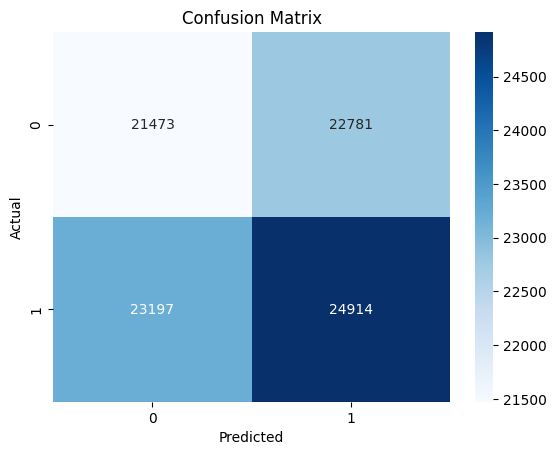

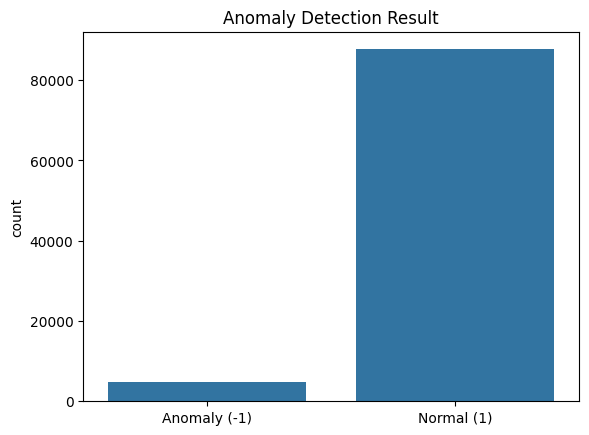

Detected Anomalies: 4688
Detected Normals: 87677


In [ ]:
classification_features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Weight',
    'Lag_Close_1', 'Lag_Return_1', 'MA_Close_5', 'Std_Close_5', 'MA_Return_5'
]
print(add_lag_features_copy_1.columns)
run_classification(df_train_copy_1, df_validate_copy_1, classification_features, target='Target_UpDown')
run_anomaly(df_train_copy_1, df_validate_copy_1, features=['Return', 'Target_Volatility', 'MA_Return_5', 'Std_Return_5'])




Train Accuracy: 0.9995893614454477
Test Accuracy: 0.5010339414280301

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.48      0.48     44254
           1       0.52      0.52      0.52     48111

    accuracy                           0.50     92365
   macro avg       0.50      0.50      0.50     92365
weighted avg       0.50      0.50      0.50     92365



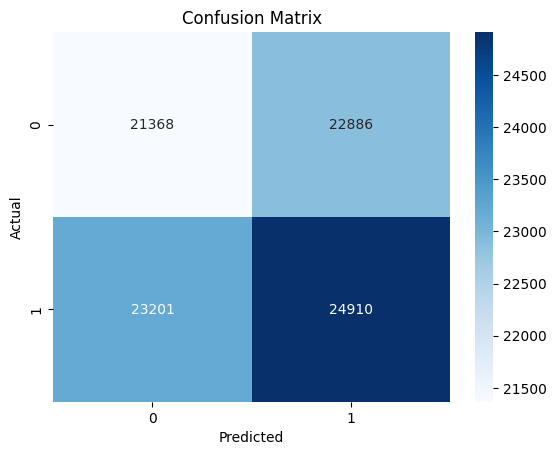

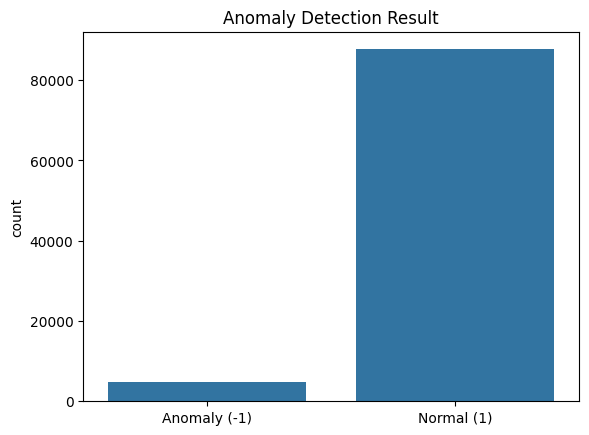

Detected Anomalies: 4688
Detected Normals: 87677


In [63]:
df_train_copy_1['Lag_UpDown_1'] = df_train_copy_1.groupby('Symbol')['Target_UpDown'].shift(1)
df_train_copy_1['Lag_UpDown_2'] = df_train_copy_1.groupby('Symbol')['Target_UpDown'].shift(2)

df_validate_copy_1['Lag_UpDown_1'] = df_validate_copy_1.groupby('Symbol')['Target_UpDown'].shift(1)
df_validate_copy_1['Lag_UpDown_2'] = df_validate_copy_1.groupby('Symbol')['Target_UpDown'].shift(2)

run_classification(df_train_copy_1, df_validate_copy_1, classification_features, target='Target_UpDown')
run_anomaly(df_train_copy_1, df_validate_copy_1, features=['Return', 'Target_Volatility', 'MA_Return_5', 'Std_Return_5'])

In [ ]:
def eda(df, columns):
    for col in columns:
        plt.figure(figsize=(12, 4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

        plt.figure(figsize=(12, 4))
        sns.stripplot(x=df[col], jitter=True)
        plt.title(f"Strip Plot of {col}")
        plt.show()

        plt.figure(figsize=(12, 4))
        sns.histplot(df[col], kde=False, bins=50)
        plt.title(f"Histogram of {col}")
        plt.show()

        plt.figure(figsize=(12, 4))
        sns.kdeplot(df[col])
        plt.title(f"KDE Plot of {col}")
        plt.show()

        plt.figure(figsize=(12, 4))
        sns.violinplot(x=df[col])
        plt.title(f"Violin Plot of {col}")
        plt.show()


def categorical_eda(df, categorical_columns):
    for col in categorical_columns:
        plt.figure(figsize=(10, 4))
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f"Countplot of {col}")
        plt.tight_layout()
        plt.show()


def bivariate_cat_cont(df, x, y):
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=df, x=x, y=y)
    plt.title(f"Line Plot of {y} vs {x}")
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x=x, y=y)
    plt.title(f"Bar Plot of {y} vs {x}")
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.pointplot(data=df, x=x, y=y)
    plt.title(f"Point Plot of {y} vs {x}")
    plt.show()


def bivariate_cont_cont(df, x, y):
    sns.jointplot(data=df, x=x, y=y, kind='scatter')
    plt.suptitle(f"Jointplot of {x} vs {y}", y=1.02)
    plt.show()

def pairwise_plot(df, columns):
    sns.pairplot(df[columns].dropna())
    plt.suptitle("Pairplot of Continuous Features", y=1.02)
    plt.show()


def multivariate_summary(df, group_by_col, summary_cols):
    summary = df.groupby(group_by_col)[summary_cols].describe().T
    print(summary)

def correlation_heatmap(df, numeric_cols):
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()


def run_all_eda():
    eda(df_companies_and_stock, ['Marketcap', 'Ebitda', 'Revenuegrowth'])
    eda(df_sp500_index, ['S&P500'])
    eda(df_companies_and_stock, ['Open', 'High', 'Low', 'Close', 'Volume'])

    # 2. Categorical EDA
    categorical_eda(df_companies_and_stock, ['Sector', 'Industry', 'Exchange'])

    # 3. Bivariate
    bivariate_cat_cont(df_companies_and_stock, 'Sector', 'Marketcap')
    bivariate_cont_cont(df_companies_and_stock, 'Open', 'Close')

    # 4. Multivariate
    pairwise_plot(df_companies_and_stock, ['Marketcap', 'Ebitda', 'Revenuegrowth'])
    multivariate_summary(df_companies_and_stock, 'Sector', ['Marketcap', 'Ebitda'])

    # 5. Correlation
    correlation_heatmap(df_companies_and_stock, ['Marketcap', 'Ebitda', 'Revenuegrowth'])

run_all_eda()


Train Accuracy: 1.0
Test Accuracy: 1.0


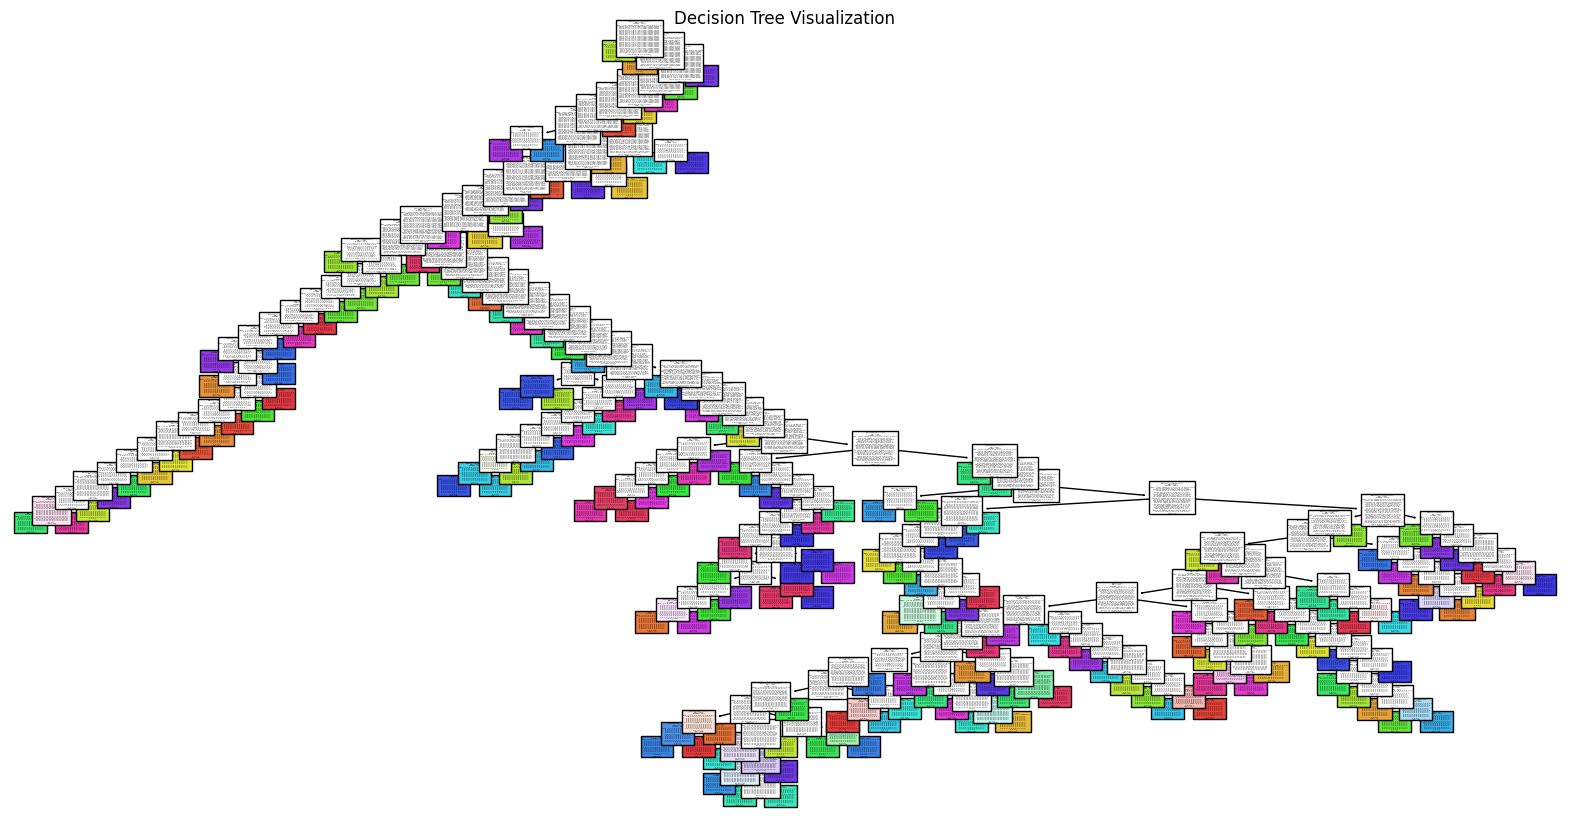

In [39]:
from sklearn import tree, metrics
import matplotlib.pyplot as plt

def train_and_plot_decision_tree(df_train, df_test, feature_cols, target_col):
 
    # 1. Split into features and labels
    X_train = df_train[feature_cols]
    y_train = df_train[target_col]
    X_test = df_test[feature_cols]
    y_test = df_test[target_col]

    # 2. Initialize and train classifier
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)

    # 3. Predictions
    y_hat = clf.predict(X_train)
    y_pred = clf.predict(X_test)

    # 4. Accuracy scores
    print("Train Accuracy:", metrics.accuracy_score(y_train, y_hat))
    print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # 5. Plot the tree
    f_names = list(X_train.columns)
    plt.figure(figsize=(20, 10))
    tree.plot_tree(clf, filled=True, feature_names=f_names, class_names=clf.classes_)
    plt.title("Decision Tree Visualization")
    plt.show()

feature_columns = ['Open', 'High', 'Low', 'Volume', 'Marketcap', 'Ebitda', 'Revenuegrowth']
target_column = 'Symbol'

train_and_plot_decision_tree(df_train, df_test, feature_columns, target_column)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(df_train, df_test, feature_cols, target_col=None):
    X_train = df_train[feature_cols]
    X_test = df_test[feature_cols]
    y_train = y_test = None

    if target_col:
        le = LabelEncoder()
        y_train = le.fit_transform(df_train[target_col])
        y_test = le.transform(df_test[target_col])
    return X_train, X_test, y_train, y_test

def train_classifier(X_train, y_train):
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    return clf

def train_anomaly_detector(X_train):
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso.fit(X_train)
    return iso

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Test Data)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate_anomaly_detector(model, X_test):
    y_pred = model.predict(X_test)
    # IsolationForest returns -1 for anomaly, 1 for normal
    anomaly_count = (y_pred == -1).sum()
    normal_count = (y_pred == 1).sum()

    print("Anomalies detected:", anomaly_count)
    print("Normal instances:", normal_count)

    plt.figure(figsize=(8,4))
    sns.countplot(x=y_pred)
    plt.title("Anomaly Detection Result (Test Set)")
    plt.xticks([0,1], ['Anomaly (-1)', 'Normal (1)'])
    plt.show()

# Define features and optional target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Marketcap', 'Ebitda', 'Revenuegrowth']
target = 'Sector'  # or None for unsupervised anomaly detection

# Prepare data
X_train, X_test, y_train, y_test = prepare_data(df_train, df_test, feature_cols=features, target_col=target)

# CLASSIFICATION
clf = train_classifier(X_train, y_train)
evaluate_classifier(clf, X_train, y_train, X_test, y_test)

# ANOMALY DETECTION
anomaly_model = train_anomaly_detector(X_train)
evaluate_anomaly_detector(anomaly_model, X_test)


In [18]:

def build_sp500_10yr_dataset( output_csv="sp500_10yr_dataset.csv"):
    # Load company info from CSV
   
    symbols = df_sp500_companies['Symbol'].dropna().unique()
    
    start_date = "2014-01-01"
    end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

    print("Fetching live market caps...")
    live_marketcaps = {}
    for symbol in symbols:
        try:
            info = yf.Ticker(symbol).info
            market_cap = info.get("marketCap")
            if market_cap:
                live_marketcaps[symbol] = market_cap
        except Exception as e:
            print(f" Could not get market cap for {symbol}: {e}")
        time.sleep(0.1)

    total_market_cap = sum(live_marketcaps.values())
    print(f"Total live market cap (S&P): {total_market_cap}")

    enriched_data = []

    for i, symbol in enumerate(symbols):
        print(f"[{i+1}/{len(symbols)}] Processing {symbol}")
        try:
            ticker = yf.Ticker(symbol)
            stock_data = ticker.history(start=start_date, end=end_date, interval="1d")

            if stock_data.empty:
                print(f" No stock data for {symbol}")
                continue

            stock_data = stock_data.reset_index()
            stock_data['Symbol'] = symbol

            # Fetch live fundamentals
            info = ticker.info
            current_price = info.get("currentPrice")
            market_cap = info.get("marketCap")
            ebitda = info.get("ebitda")
            revenue_growth = info.get("revenueGrowth")
            weight = (market_cap / total_market_cap) * 100 if market_cap and total_market_cap else None

            # Get static metadata from CSV
            company_row = df_sp500_companies[df_sp500_companies['Symbol'] == symbol].iloc[0]
            static_fields = {
                "Exchange": company_row.get("Exchange"),
                "Shortname": company_row.get("Shortname"),
                "Longname": company_row.get("Longname"),
                "Sector": company_row.get("Sector"),
                "Industry": company_row.get("Industry"),
            }

            # Add fundamentals to stock data
            stock_data["CurrentPrice"] = current_price
            stock_data["MarketCap"] = market_cap
            stock_data["EBITDA"] = ebitda
            stock_data["RevenueGrowth"] = revenue_growth
            stock_data["Weight"] = weight

            # Add static fields
            for key, val in static_fields.items():
                stock_data[key] = val

            # Keep required columns
            stock_data = stock_data[[
                "Date", "Symbol", "Open", "High", "Low", "Close", "Volume",
                "CurrentPrice", "MarketCap", "EBITDA", "RevenueGrowth", "Weight",
                "Exchange", "Shortname", "Longname", "Sector", "Industry"
            ]]

            enriched_data.append(stock_data)
        except Exception as e:
            print(f"Failed for {symbol}: {e}")
        time.sleep(0.1)

    # Combine and save
    if enriched_data:
        final_df = pd.concat(enriched_data, ignore_index=True)
        final_df.to_csv(output_csv, index=False)
        print(f"\nSaved enriched 10-year dataset to {output_csv}")
    else:
        print("\nNo valid data collected.")



build_sp500_10yr_dataset()

Fetching live market caps...
Total live market cap (S&P): 55441967041024
[1/502] Processing AAPL
[2/502] Processing NVDA
[3/502] Processing MSFT
[4/502] Processing AMZN
[5/502] Processing GOOGL
[6/502] Processing GOOG
[7/502] Processing META
[8/502] Processing TSLA
[9/502] Processing AVGO
[10/502] Processing BRK-B
[11/502] Processing WMT
[12/502] Processing LLY
[13/502] Processing JPM
[14/502] Processing V
[15/502] Processing MA
[16/502] Processing ORCL
[17/502] Processing XOM
[18/502] Processing UNH
[19/502] Processing COST
[20/502] Processing PG
[21/502] Processing HD
[22/502] Processing NFLX
[23/502] Processing JNJ
[24/502] Processing BAC
[25/502] Processing CRM
[26/502] Processing ABBV
[27/502] Processing KO
[28/502] Processing TMUS
[29/502] Processing CVX
[30/502] Processing MRK
[31/502] Processing WFC
[32/502] Processing CSCO
[33/502] Processing ACN
[34/502] Processing NOW
[35/502] Processing AXP
[36/502] Processing MCD
[37/502] Processing PEP
[38/502] Processing BX
[39/502] Proc

C:\Users\atul1\AppData\Local\Temp\ipykernel_26176\1624066679.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(enriched_data, ignore_index=True)



Saved enriched 10-year dataset to sp500_10yr_dataset.csv


In [19]:
df_new = pd.read_csv("sp500_10yr_dataset.csv")
df_new.isnull().sum()



Date                 0
Symbol               0
Open                 1
High                 1
Low                  1
Close                1
Volume               0
CurrentPrice         0
MarketCap            0
EBITDA           80051
RevenueGrowth     2871
Weight               0
Exchange             0
Shortname            0
Longname             0
Sector               0
Industry             0
dtype: int64

In [21]:
def fill_missing_stock_data_fast( output_file="sp500_stocks_data_engineered.csv"):
    missing_rows = df_sp500_stocks[df_sp500_stocks.isnull().any(axis=1)]
    symbols_with_missing = missing_rows['Symbol'].unique()
    total = len(symbols_with_missing)

    for i, symbol in enumerate(symbols_with_missing):
        symbol_missing_dates = missing_rows[missing_rows['Symbol'] == symbol]['Date'].dropna().unique()
        if len(symbol_missing_dates) == 0:
            continue

        print(f"[{i+1}/{total}] Processing {symbol} with {len(symbol_missing_dates)} missing dates...")

        # Use the min/max date to fetch a batch
        start_date = pd.to_datetime(symbol_missing_dates.min()).strftime('%Y-%m-%d')
        end_date = (pd.to_datetime(symbol_missing_dates.max()) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

        try:
            yf_data = yf.download(symbol, start=start_date, end=end_date, interval="1d", progress=False)
            if yf_data.empty:
                print(f"No data fetched for {symbol} between {start_date} and {end_date}")
                continue

            yf_data.index = pd.to_datetime(yf_data.index)
            for date in symbol_missing_dates:
                date = pd.to_datetime(date)
                if date in yf_data.index:
                    row = yf_data.loc[date]
                    df_sp500_stocks.loc[(df_sp500_stocks['Symbol'] == symbol) & (df_sp500_stocks['Date'] == date), [
                        'Open', 'High', 'Low', 'Close', 'Volume'
                    ]] = row[['Open', 'High', 'Low', 'Close', 'Volume']].values
        except Exception as e:
            print(f"Error fetching batch for {symbol}: {e}")

        time.sleep(0.1)  # avoid hitting rate limits

    df_sp500_stocks.to_csv(output_file, index=False)
    print(f"Saved updated stock data to {output_file}")
    return df_sp500_stocks

fill_missing_stock_data_fast()

[1/352] Processing MMM with 3768 missing dates...
[2/352] Processing ABBV with 754 missing dates...



1 Failed download:
['ABBV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2013-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1357016400")')


No data fetched for ABBV between 2010-01-04 and 2013-01-01
[3/352] Processing ACN with 3768 missing dates...
[4/352] Processing ADBE with 3768 missing dates...
[5/352] Processing AMD with 3768 missing dates...
[6/352] Processing AFL with 3768 missing dates...
[7/352] Processing A with 3768 missing dates...
[8/352] Processing APD with 3768 missing dates...
[9/352] Processing ABNB with 3768 missing dates...
[10/352] Processing AKAM with 3768 missing dates...
[11/352] Processing ARE with 3768 missing dates...
[12/352] Processing ALGN with 3768 missing dates...
[13/352] Processing ALLE with 976 missing dates...



1 Failed download:
['ALLE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2013-11-16) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1384578000")')


No data fetched for ALLE between 2010-01-04 and 2013-11-16
[14/352] Processing LNT with 3768 missing dates...
[15/352] Processing GOOGL with 3768 missing dates...
[16/352] Processing AMCR with 3768 missing dates...
[17/352] Processing AMTM with 3768 missing dates...
[18/352] Processing AEE with 3768 missing dates...
[19/352] Processing AEP with 3768 missing dates...
[20/352] Processing AIG with 3768 missing dates...
[21/352] Processing AMT with 3768 missing dates...
[22/352] Processing AWK with 3768 missing dates...
[23/352] Processing AME with 3768 missing dates...
[24/352] Processing AMGN with 3768 missing dates...
[25/352] Processing ADI with 3768 missing dates...
[26/352] Processing AON with 3768 missing dates...
[27/352] Processing APA with 3768 missing dates...
[28/352] Processing AAPL with 3768 missing dates...
[29/352] Processing AMAT with 3768 missing dates...
[30/352] Processing APTV with 3768 missing dates...
[31/352] Processing ACGL with 3768 missing dates...
[32/352] Proce


1 Failed download:
['ANET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2014-06-06) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1402027200")')


No data fetched for ANET between 2010-01-04 and 2014-06-06
[33/352] Processing AIZ with 3768 missing dates...
[34/352] Processing ATO with 3768 missing dates...
[35/352] Processing ADSK with 3768 missing dates...
[36/352] Processing ADP with 3768 missing dates...
[37/352] Processing AZO with 3768 missing dates...
[38/352] Processing AVB with 3768 missing dates...
[39/352] Processing AVY with 3768 missing dates...
[40/352] Processing BALL with 3768 missing dates...
[41/352] Processing BAC with 3768 missing dates...
[42/352] Processing BRK-B with 3768 missing dates...
[43/352] Processing TECH with 3768 missing dates...
[44/352] Processing BIIB with 3768 missing dates...
[45/352] Processing BLK with 3768 missing dates...
[46/352] Processing BX with 3768 missing dates...
[47/352] Processing BA with 3768 missing dates...
[48/352] Processing BKNG with 3768 missing dates...
[49/352] Processing BMY with 3768 missing dates...
[50/352] Processing AVGO with 3768 missing dates...
[51/352] Processi


1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2016-08-17) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1471406400")')


No data fetched for DELL between 2010-01-04 and 2016-08-17
[103/352] Processing DAL with 3768 missing dates...
[104/352] Processing DVN with 3768 missing dates...
[105/352] Processing FANG with 3768 missing dates...
[106/352] Processing DLTR with 3768 missing dates...
[107/352] Processing D with 3768 missing dates...
[108/352] Processing DOW with 3768 missing dates...
[109/352] Processing DUK with 3768 missing dates...
[110/352] Processing DD with 3768 missing dates...
[111/352] Processing ETN with 3768 missing dates...
[112/352] Processing EBAY with 3768 missing dates...
[113/352] Processing ECL with 3768 missing dates...
[114/352] Processing EW with 3768 missing dates...
[115/352] Processing ELV with 3768 missing dates...
[116/352] Processing EMR with 3768 missing dates...
[117/352] Processing ENPH with 565 missing dates...



1 Failed download:
['ENPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2012-03-30) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1333080000")')


No data fetched for ENPH between 2010-01-04 and 2012-03-30
[118/352] Processing ETR with 3768 missing dates...
[119/352] Processing EOG with 3768 missing dates...
[120/352] Processing EPAM with 3768 missing dates...
[121/352] Processing ERIE with 3768 missing dates...
[122/352] Processing EG with 3768 missing dates...
[123/352] Processing EVRG with 3768 missing dates...
[124/352] Processing ES with 3768 missing dates...
[125/352] Processing EXC with 3768 missing dates...
[126/352] Processing EXPD with 3768 missing dates...
[127/352] Processing EXR with 3768 missing dates...
[128/352] Processing XOM with 3768 missing dates...
[129/352] Processing FICO with 3768 missing dates...
[130/352] Processing FIS with 3768 missing dates...
[131/352] Processing FITB with 3768 missing dates...
[132/352] Processing FE with 3768 missing dates...
[133/352] Processing FI with 3768 missing dates...
[134/352] Processing FMC with 3768 missing dates...
[135/352] Processing F with 3768 missing dates...
[136/


1 Failed download:
['FOXA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2019-03-12) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1552363200")')


No data fetched for FOXA between 2010-01-04 and 2019-03-12
[138/352] Processing FOX with 2312 missing dates...



1 Failed download:
['FOX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2019-03-13) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1552449600")')


No data fetched for FOX between 2010-01-04 and 2019-03-13
[139/352] Processing GRMN with 3768 missing dates...
[140/352] Processing IT with 3768 missing dates...
[141/352] Processing GE with 3768 missing dates...
[142/352] Processing GEHC with 3768 missing dates...
[143/352] Processing GEV with 3768 missing dates...
[144/352] Processing GEN with 3768 missing dates...
[145/352] Processing GNRC with 3768 missing dates...
[146/352] Processing GD with 3768 missing dates...
[147/352] Processing GM with 3768 missing dates...
[148/352] Processing GPC with 3768 missing dates...
[149/352] Processing GILD with 3768 missing dates...
[150/352] Processing GL with 3768 missing dates...
[151/352] Processing GDDY with 1318 missing dates...



1 Failed download:
['GDDY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2015-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1427774400")')


No data fetched for GDDY between 2010-01-04 and 2015-03-31
[152/352] Processing GS with 3768 missing dates...
[153/352] Processing HAL with 3768 missing dates...
[154/352] Processing HAS with 3768 missing dates...
[155/352] Processing HCA with 298 missing dates...



1 Failed download:
['HCA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2011-03-10) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1299733200")')


No data fetched for HCA between 2010-01-04 and 2011-03-10
[156/352] Processing DOC with 3768 missing dates...
[157/352] Processing HSY with 3768 missing dates...
[158/352] Processing HES with 3768 missing dates...
[159/352] Processing HPE with 1458 missing dates...



1 Failed download:
['HPE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2015-10-17) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1445054400")')


No data fetched for HPE between 2010-01-04 and 2015-10-17
[160/352] Processing HLT with 993 missing dates...



1 Failed download:
['HLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-04 -> 2013-12-12) (Yahoo error = "Data doesn\'t exist for startDate = 1262581200, endDate = 1386824400")')


No data fetched for HLT between 2010-01-04 and 2013-12-12
[161/352] Processing HOLX with 3768 missing dates...
[162/352] Processing HD with 3768 missing dates...
[163/352] Processing HON with 3768 missing dates...
[164/352] Processing HWM with 3768 missing dates...
[165/352] Processing HPQ with 3768 missing dates...


KeyboardInterrupt: 